In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import base

TAIL = 3
LENGTH = 15


In [2]:
def position_approximate_distance_to_target():
    grouped_type = pd.read_csv('result_collection.csv').sort_values(['timestamp']).groupby('display_type')

    top = []
    som = []

    feedback_indexes = []
    for i in range(64):
        feedback_indexes.append('D' + str(i) + '_distance_to_target')

    for _, group in grouped_type:
        group = base.filter_out_mess(group)
        distance = group[group['type'] == 'feedback'][feedback_indexes]

        if group.iloc[0]["display_type"] == "top":
            top = distance.median(axis=0)
        else:
            som = distance.median(axis=0)

    return som, top


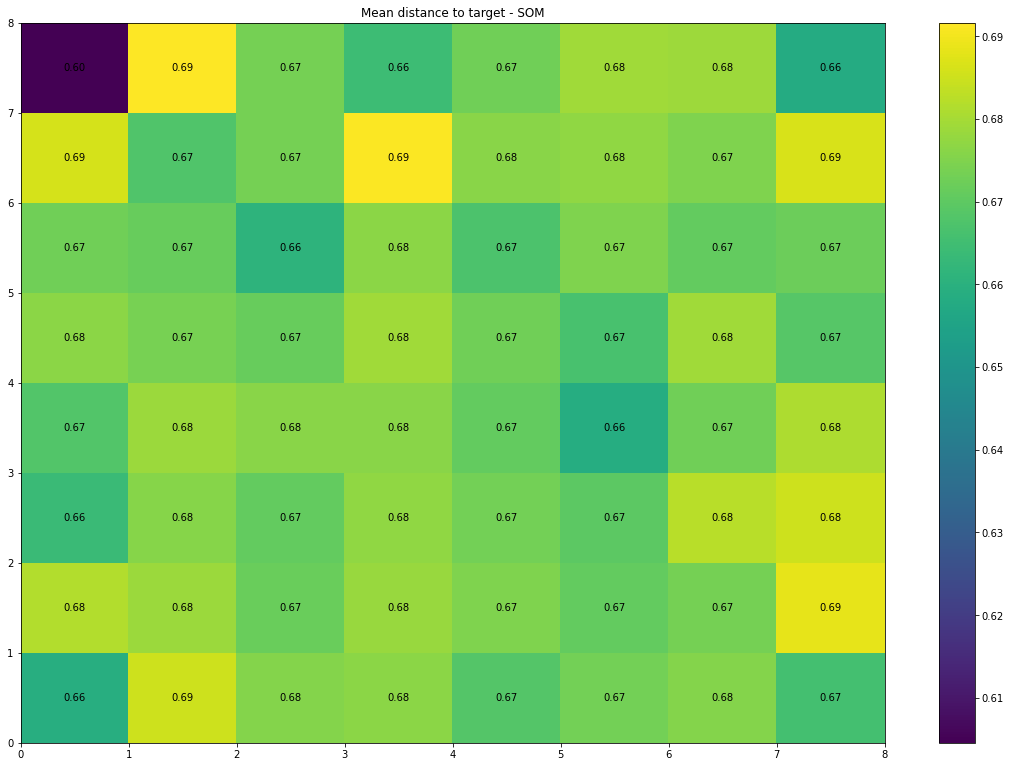

<Figure size 1440x1440 with 0 Axes>

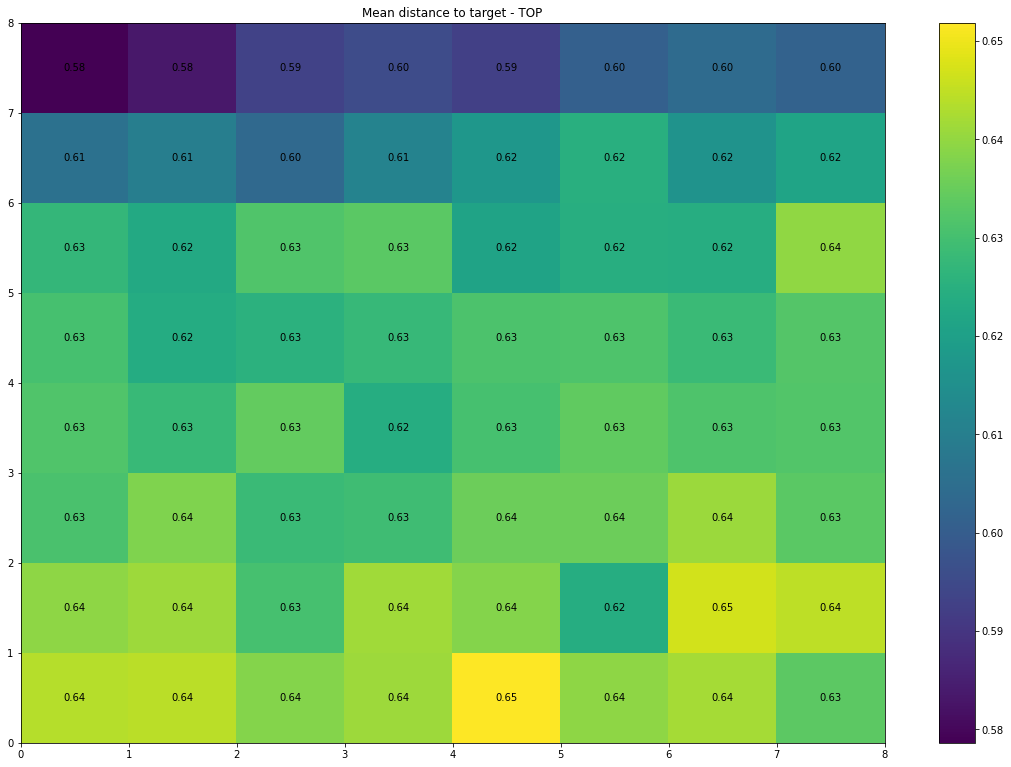

<Figure size 1440x1440 with 0 Axes>

In [3]:
som, top = position_approximate_distance_to_target()
type = "SOM"
for data in [som, top]:
    %matplotlib inline
    fig, ax = plt.subplots()
    data = data.to_numpy()
    data = np.reshape(data, (-1, 8))[::-1]
    heatmap = plt.pcolor(data)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            plt.text(x + 0.5, y + 0.5, "{:.2f}".format(data[y, x]),
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    plt.title("Mean distance to target - " + type)

    plt.colorbar(heatmap)
    
    plt.figure(figsize=(20,20))
    fig.subplots_adjust(0,0,2.5,2.5) # make plots bigger in Jupyter

    plt.show()
    type = "TOP"

In [4]:
def position_feedback_frequency():
    grouped_users = base.get_dataset_and_group_by_user()
    top = []
    som = []

    feedback_indexes = []
    for i in range(64):
        feedback_indexes.append('D' + str(i)+ '_is_selected')

    for username, group in grouped_users:
        group = base.filter_out_mess(group)
        group_by_target = group.groupby('target_id')

        for target, target_group in group_by_target:

            feedback = target_group[target_group['type'] == 'feedback'][feedback_indexes].astype(int)

            feedback = pd.DataFrame(feedback.sum(axis=0))

            if target_group.iloc[0]["display_type"] == "top":
                top = pd.concat([pd.DataFrame(feedback),pd.DataFrame(top)], axis=1)
            else:
                som = pd.concat([pd.DataFrame(feedback),pd.DataFrame(som)], axis=1)

    som = som.sum(axis=1)
    top = top.sum(axis=1)

    return som, top

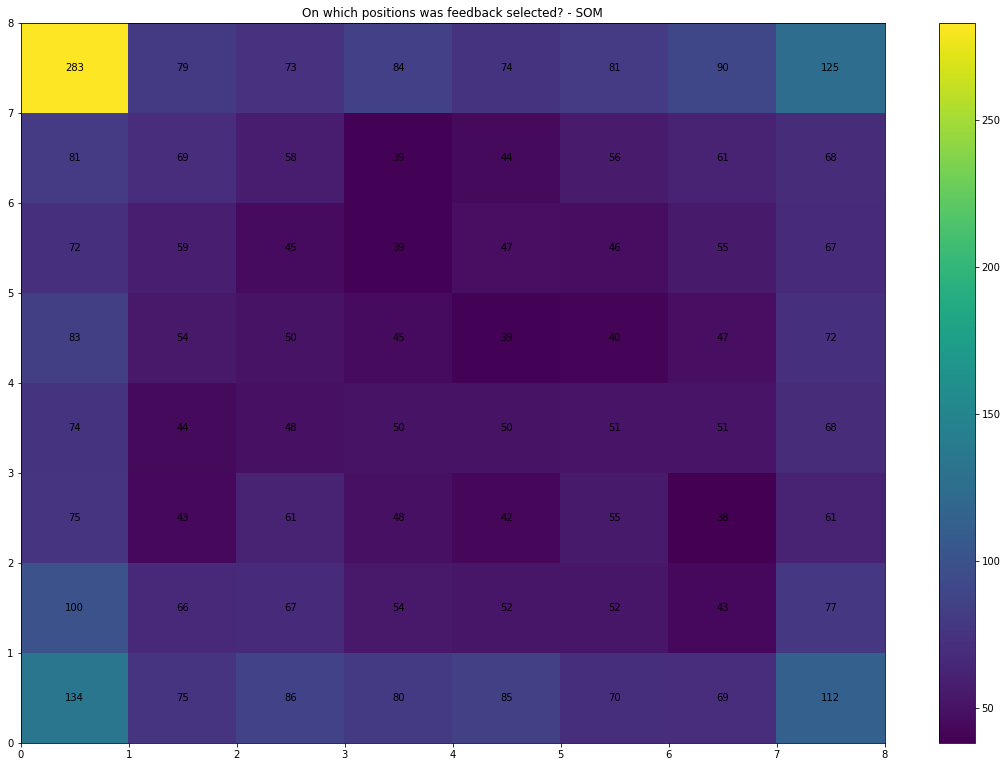

<Figure size 1440x1440 with 0 Axes>

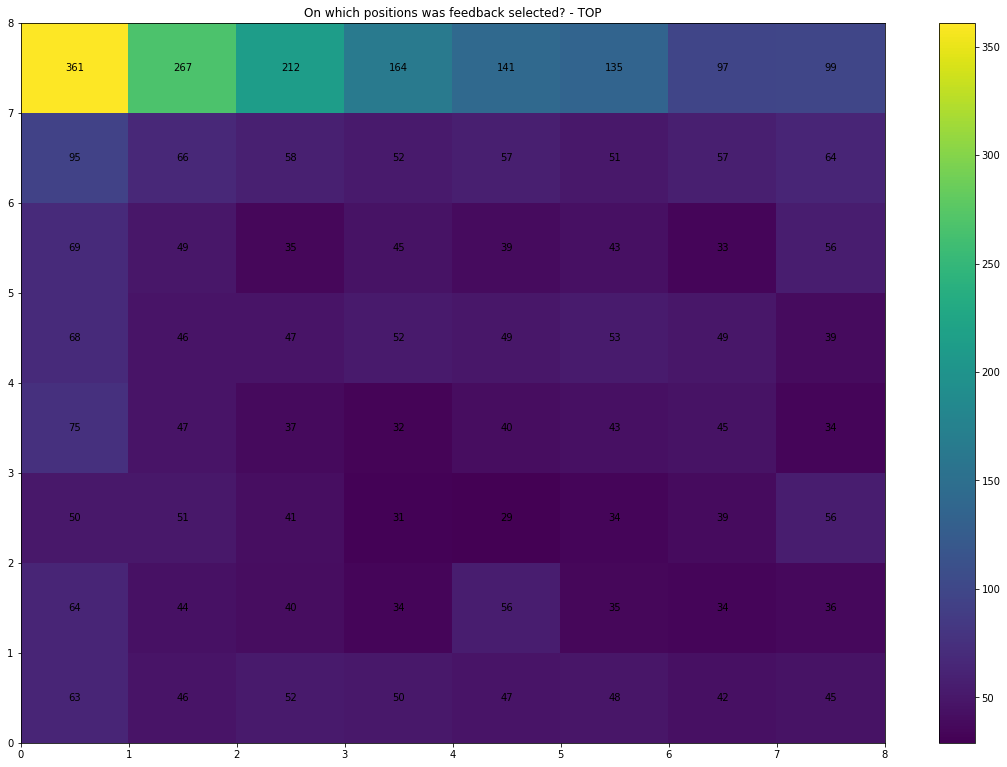

<Figure size 1440x1440 with 0 Axes>

In [5]:
som, top = position_feedback_frequency()
type = "SOM"
for data in [som, top]:
    %matplotlib inline
    fig, ax = plt.subplots()
    data = data.to_numpy()
    data = np.reshape(data, (-1, 8))[::-1]
    heatmap = plt.pcolor(data)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%d' % data[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )

    plt.colorbar(heatmap)
    plt.title("On which positions was feedback selected? - " + type)
    plt.figure(figsize=(20,20))
    fig.subplots_adjust(0,0,2.5,2.5) # make plots bigger in Jupyter

    plt.show()
    type = "TOP"

In [6]:
def get_novelty_and_distance():
    grouped_users = base.get_dataset_and_group_by_user()

    id_indexes = []
    distance_indexes = []

    success_novelty = []
    success_distance =[]
    fail_novelty = []
    fail_distance = []

    for i in range(64):
        distance_indexes.append('D' + str(i) + '_distance_to_target')
        id_indexes.append('D' + str(i) + '_id')

    for username, group in grouped_users:
        group = base.filter_out_mess(group)
        group_by_target = group.groupby('target_id')

        for target, target_group in group_by_target:
            if target_group.shape[0] < 5:
                continue
            distances = target_group[distance_indexes]
            ids = target_group[id_indexes]
            result_ratios_novelty = []
            result_average_distances = []

            id_set = set()

            for i in range(target_group.shape[0]):
                # get novelty ratio
                n_of_old_items = len(id_set.intersection(ids.iloc[i]))
                id_set.update(ids.iloc[i])
                n_of_new_items = 64 - n_of_old_items
                ratio = n_of_new_items / 64.0
                result_ratios_novelty.append(ratio)

                # get median distance
                median_distance = distances.iloc[i].mean()
                result_average_distances.append(median_distance)

            result_ratios_novelty = list(reversed(result_ratios_novelty))[:TAIL]
            result_average_distances = list(reversed(result_average_distances))[:TAIL]

            point_novelty = sum(result_ratios_novelty) / len(result_ratios_novelty)
            point_distance = sum(result_average_distances) / len(result_average_distances)
            if target_group[target_group['guess_video'] == target_group['target_video']].empty:
                fail_distance.append(point_distance)
                fail_novelty.append(point_novelty)
            else:
                success_distance.append(point_distance)
                success_novelty.append(point_novelty)

    return success_distance, success_novelty, fail_distance, fail_novelty

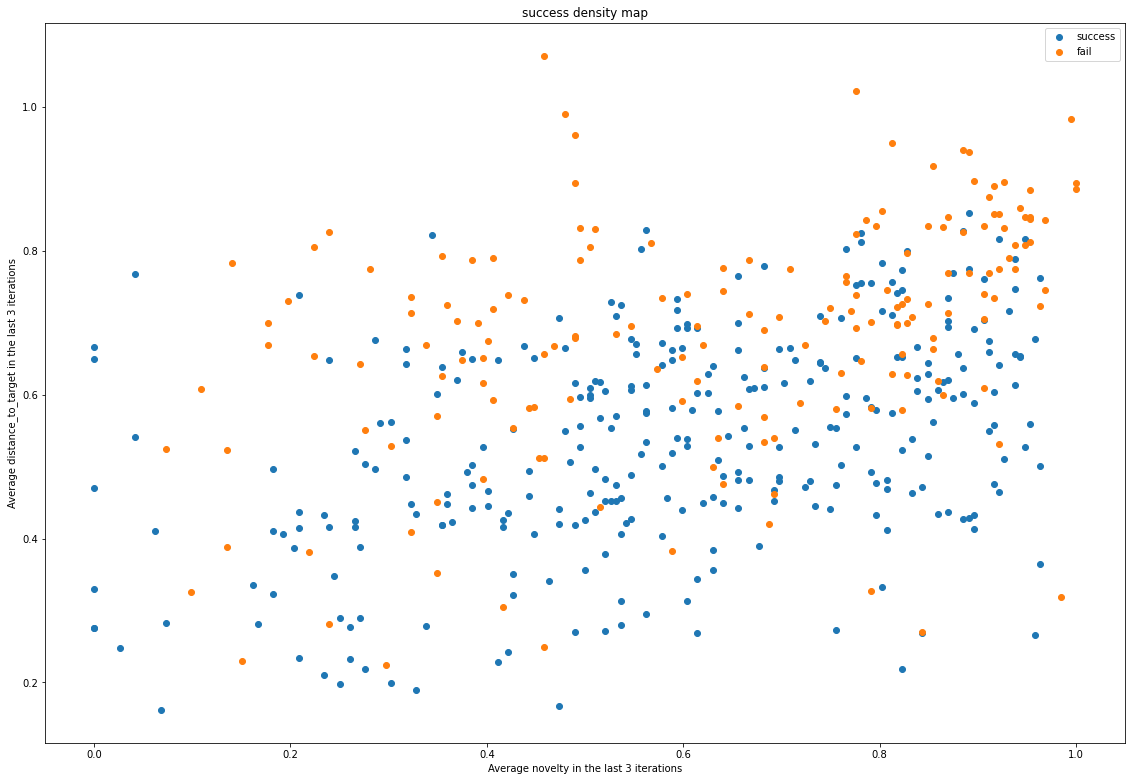

<Figure size 1440x1440 with 0 Axes>

In [7]:
%matplotlib inline
fig, ax = plt.subplots()

success_distance, success_novelty, fail_distance, fail_novelty = get_novelty_and_distance()

plt.scatter(success_novelty, success_distance, label="success")
plt.scatter(fail_novelty, fail_distance, label="fail")
plt.legend(loc="upper right")
plt.title("success density map")
plt.xlabel('Average novelty in the last ' + str(TAIL) + ' iterations')
plt.ylabel('Average distance_to_target in the last ' + str(TAIL) + ' iterations')

plt.figure(figsize=(20,20))
fig.subplots_adjust(0,0,2.5,2.5) # make plots bigger in Jupyter

plt.show()

In [8]:
def all_target_frequency():
    grouped_type = pd.read_csv('result_collection.csv').sort_values(['timestamp']).groupby('display_type')

    top = [0] * 64
    som = [0] * 64

    id_indexes = []
    for i in range(64):
        id_indexes.append('D' + str(i) + '_id')
    #id_indexes.append("guess_id")
    for _, group in grouped_type:
        group = base.filter_out_mess(group)

        id_group = group[id_indexes]

        submits = id_group.isin(group['target_id'])

        if group.iloc[0]["display_type"] == "top":
            top = submits.sum(axis=0)
        else:
            som = submits.sum(axis=0)

    return som, top

In [9]:
def submit_frequency():
    grouped_type = pd.read_csv('result_collection.csv').sort_values(['timestamp']).groupby('display_type')

    top = [0] * 64
    som = [0] * 64

    id_indexes = []
    for i in range(64):
        id_indexes.append('D' + str(i) + '_id')
    #id_indexes.append("guess_id")
    for _, group in grouped_type:
        group = base.filter_out_mess(group)
        group = group[group["target_id"] == group["guess_id"]]

        id_group = group[id_indexes]

        submits = id_group.isin(group['guess_id'])

        if group.iloc[0]["display_type"] == "top":
            top = submits.sum(axis=0)
        else:
            som = submits.sum(axis=0)

    return som, top


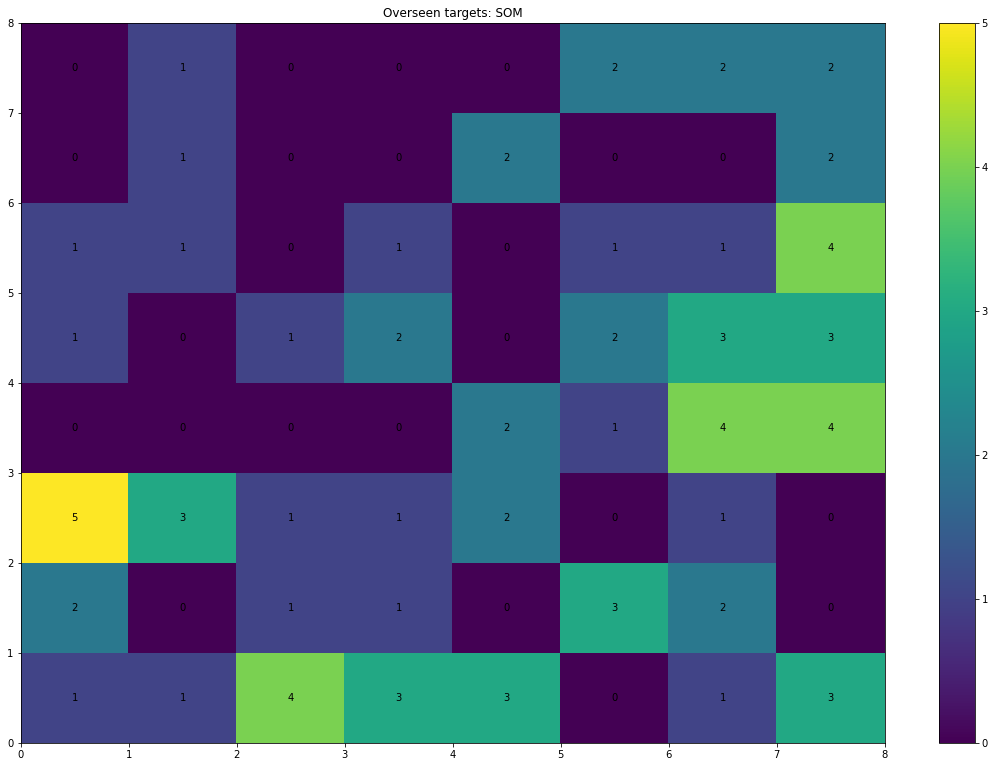

<Figure size 1440x1440 with 0 Axes>

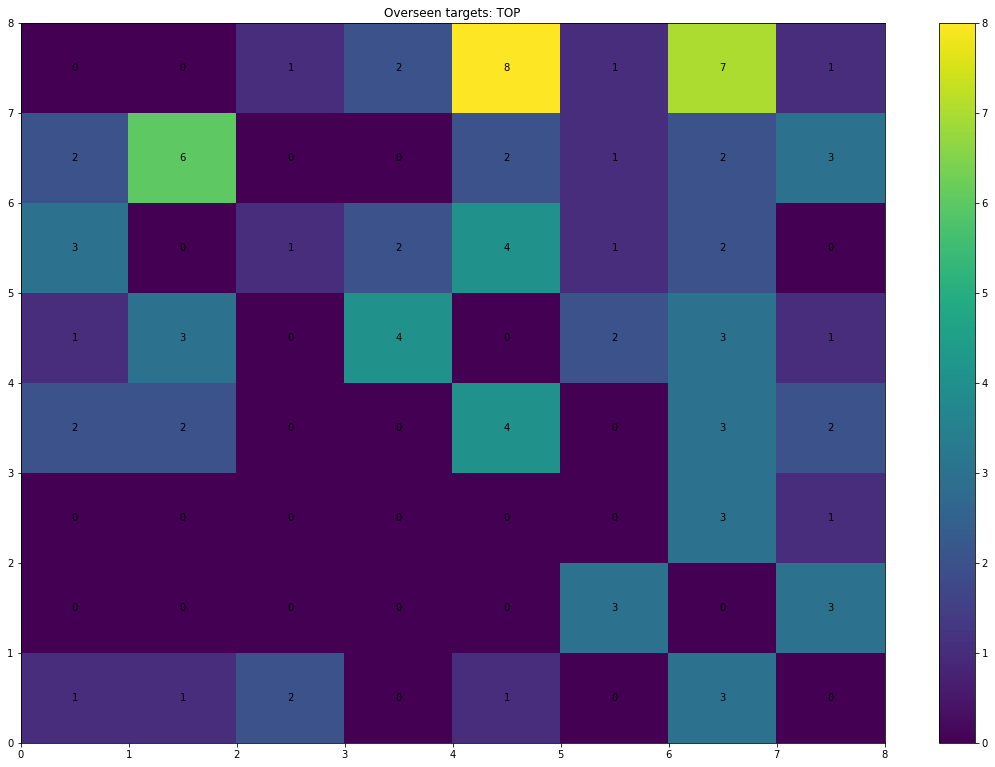

<Figure size 1440x1440 with 0 Axes>

In [10]:
all_som, all_top = all_target_frequency()
submit_som, submit_top = submit_frequency()
som = all_som - submit_som
top = all_top - submit_top
type = "SOM"
for data in [som, top]:
    %matplotlib inline
    fig, ax = plt.subplots()
    data = data.to_numpy()
    data = np.reshape(data, (-1, 8))[::-1]
    heatmap = plt.pcolor(data)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%d' % data[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    plt.title("Overseen targets: " + type + " (target was displayed but wasn't submitted)")

    plt.colorbar(heatmap)
    
    plt.figure(figsize=(20,20))
    fig.subplots_adjust(0,0,2.5,2.5) # make plots bigger in Jupyter

    plt.show()
    type = "TOP"

In [11]:
def submit_positions():
    grouped_type = pd.read_csv('result_collection.csv').sort_values(['timestamp']).groupby('display_type')

    top = [0] * 64
    som = [0] * 64

    id_indexes = []
    for i in range(64):
        id_indexes.append('D' + str(i) + '_id')
    #id_indexes.append("guess_id")
    for _, group in grouped_type:
        group = base.filter_out_mess(group)
        group = group[group["target_id"] == group["guess_id"]]

        id_group = group[id_indexes]

        submits = id_group.isin(group['guess_id'])

        if group.iloc[0]["display_type"] == "top":
            top = submits.sum(axis=0)
        else:
            som = submits.sum(axis=0)

    return som, top

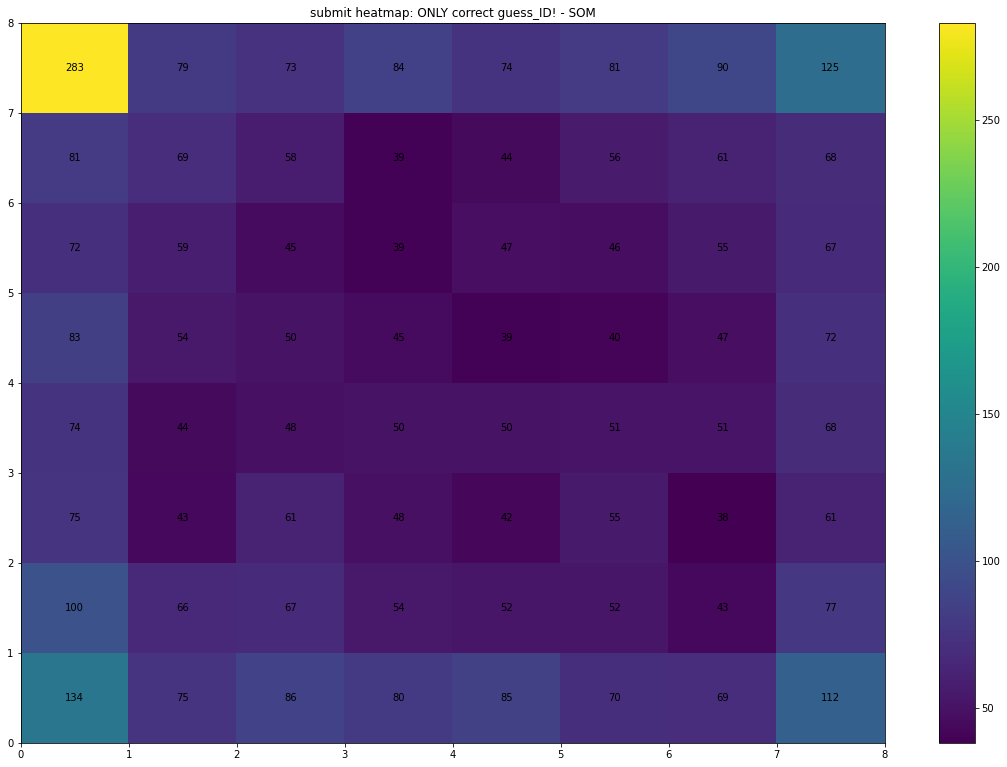

<Figure size 1440x1440 with 0 Axes>

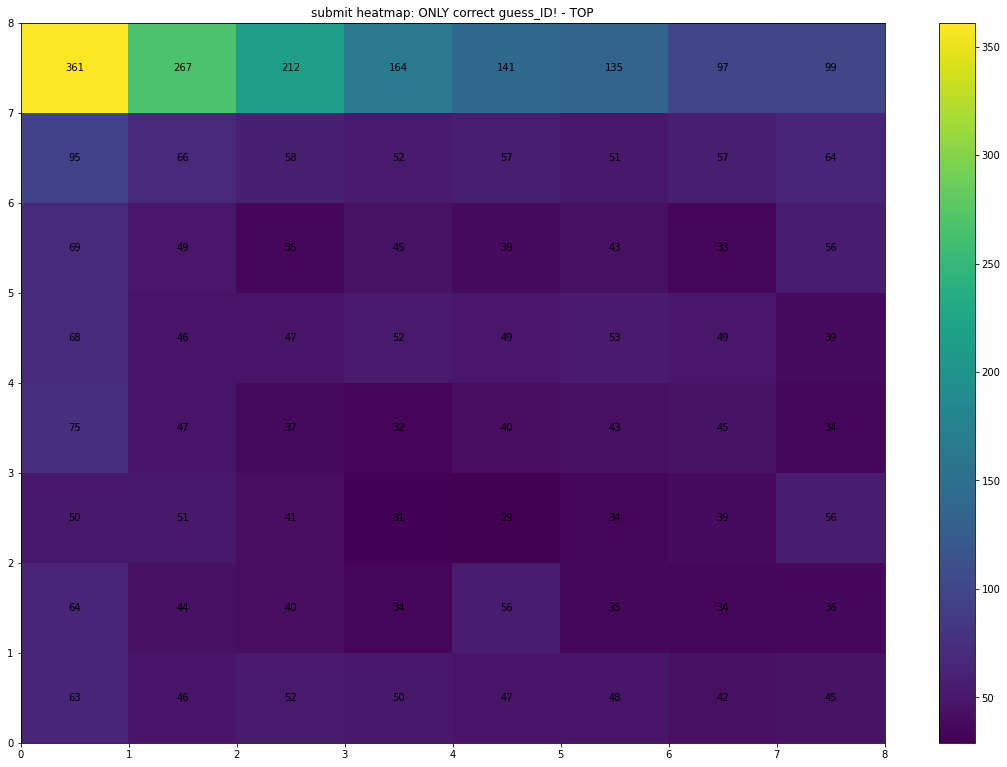

<Figure size 1440x1440 with 0 Axes>

In [12]:
som, top = position_feedback_frequency()
type = "SOM"
for data in [som, top]:
    %matplotlib inline
    fig, ax = plt.subplots()
    data = data.to_numpy()
    data = np.reshape(data, (-1, 8))[::-1]
    heatmap = plt.pcolor(data)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%d' % data[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    plt.title("submit heatmap: ONLY correct guess_ID - " + type)

    plt.colorbar(heatmap)

    plt.figure(figsize=(20,20))
    fig.subplots_adjust(0,0,2.5,2.5) # make plots bigger in Jupyter

    plt.show()
    type = "TOP"